# Autocorrelation
In this notebook the autocorrelation analysis is presented as describe in [Doumanlin et al. 2003](https://doi.org/10.1016/j.mecind.2003.09.002).

## Import packages

In [1]:
import xarray_image_processing.xarray_image_processing as ximP

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import xarray_dic.xarray_dic as xd
import xarray_dic.loadDIC as xldic
import xarray_symTensor2d.xarray_symTensor2d as xst

## Import data

In [2]:
res=0.0112 # mm/pix
s_dic=0.005 # % deformation
unit_time='macro_strain'
unit_spa='millimeter'
hws_window=30
box_size=np.array(hws_window)*res

In [3]:
path='/data/FlorianFiguiere/GI06/spam/nm_analysis/SP1_new/'
dataSp1=[]
macrostrain=[]


ds_int=xldic.multi_load(xldic.loadSpam,path+'disp/n'+str(hws_window)+'/',res,s_dic,unit_time=unit_time,unit_res=unit_spa) #More than one correlation
ds=ds_int.dic.dic_average()

ds['eqVM']=ds.strain.sT.eqVonMises(lognorm=False)
ds['eqVM_LN']=ds.strain.sT.eqVonMises(lognorm=True)
ds['mean_eyy']=ds.strain.sT.mean('tyy')
ds['dl_y']=ds.dic.DIC_line('y')

## The image

In [4]:
ds.eqVM[0,...]

<xarray.DataArray 'eqVM' (y: 242, x: 101)>
array([[0.01170709, 0.00833665, 0.00505024, ..., 0.00444757, 0.00495407,
        0.00197812],
       [0.01446941, 0.00895503, 0.00549232, ..., 0.00808005, 0.00379695,
        0.00125359],
       [0.01041088, 0.01073611, 0.01098853, ..., 0.00451332, 0.00794226,
        0.00784102],
       ...,
       [0.00484289, 0.00430023, 0.0092179 , ..., 0.00663892, 0.00526871,
        0.00459541],
       [0.00773019, 0.00715294, 0.01071609, ..., 0.0055062 , 0.00566613,
        0.005399  ],
       [0.01022258, 0.01077604, 0.00912585, ..., 0.00413035, 0.00190815,
        0.00263242]])
Coordinates:
    time     float64 0.005
  * x        (x) float64 11.26 11.59 11.93 12.26 ... 43.85 44.18 44.52 44.86
  * y        (y) float64 2.856 3.192 3.528 3.864 4.2 ... 82.82 83.16 83.5 83.83

(11.088000000000001, 45.024, 2.6879999999999997, 84.0)

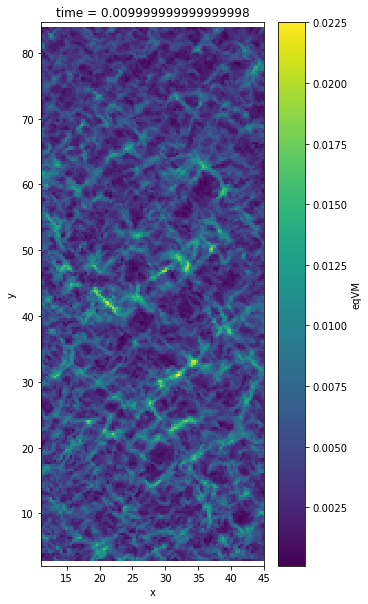

In [5]:
plt.figure(figsize=(5,10))
ds.eqVM[1,...].plot()
plt.axis('equal')

## Performed the autocorrelation

In [6]:
ds_auto=ds.eqVM[1,...].imP.auto_correlation(pad=2)

## What does the analysis contained ?
### The autocorrelation function

(-0.16800000000000015,
 67.70400000000006,
 -0.16800000000000015,
 162.45600000000016)

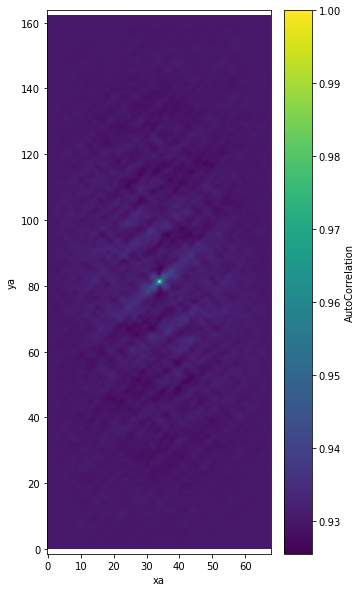

In [7]:
plt.figure(figsize=(5,10))
ds_auto.AutoCorrelation.plot()
plt.axis('equal')

### The $C_{inf}$ value

In [8]:
print(float(ds_auto.Cinf))

0.9303233199360058


This value can be interesting to normalized the autocorrelation function using $AC_N=log\left(\frac{AC}{C_{inf}}\right)$. Using this normalized fucntion allow easy reading :

- AC_N > 0 : correlation better than random
- AC_N = 0 : no correlation
- AC_N < 0 : anti correlation better than random

In [9]:
AC_N=np.log(ds_auto.AutoCorrelation/ds_auto.Cinf)
plt.figure(figsize=(5,10))
AC_N.plot()
plt.axis('equal')

(-0.16800000000000015,
 67.70400000000006,
 -0.16800000000000015,
 162.45600000000016)

### A profil of the autocorrelation function for every degree

Autocorrelation profile are stored in $P\theta$
- $\theta = 0$ means along +x
- $\theta = 90$ means along +y

In [10]:
plt.figure(figsize=(10,6))
ds_auto.P0.plot(label='$\\theta=0^{\circ}$')
ds_auto.P45.plot(label='$\\theta=90^{\circ}$')
plt.plot([0,60],[ds_auto.Cinf,ds_auto.Cinf])
plt.legend()
plt.grid()

### The correlationn length

#### Intersection formulation

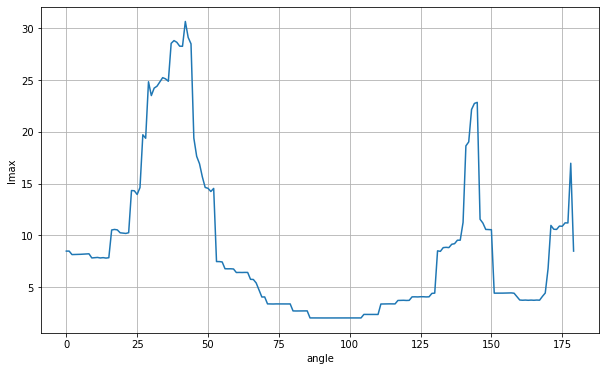

In [11]:
plt.figure(figsize=(10,6))
ds_auto.lmax.plot()
plt.grid()

Those result can be plot in a polar plot for eaier reading

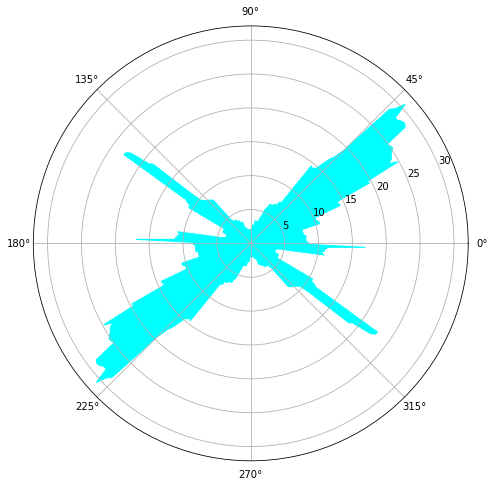

In [12]:
plt.figure(figsize=(8,8))
plt.subplot(projection='polar')
theta = np.linspace(0,359,360)*np.pi/180
theta = np.linspace(0,359,360)*np.pi/180
ll=np.concatenate([ds_auto.lmax,ds_auto.lmax])
plt.fill(theta, ll,color='cyan')

#### Integral formulation

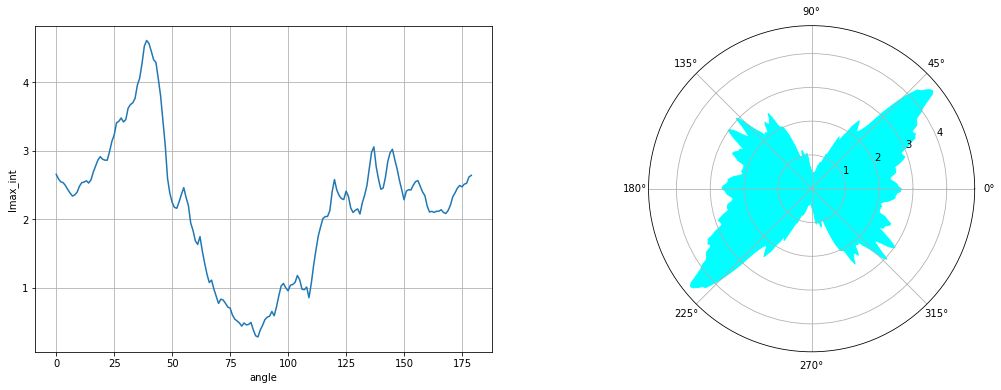

In [13]:
plt.figure(figsize=(18,6))
plt.subplot(121)
ds_auto.lmax_int.plot()
plt.grid()
plt.subplot(122,projection='polar')
theta = np.linspace(0,359,360)*np.pi/180
theta = np.linspace(0,359,360)*np.pi/180
ll=np.concatenate([ds_auto.lmax_int,ds_auto.lmax_int])
plt.fill(theta, ll,color='cyan')

### Correlation length with time

In [14]:
auto_lmax=np.zeros([len(ds.time),180])
auto_lmax_int=np.zeros([len(ds.time),180])

for t in range(len(ds.time)):
    ds_at=ds.eqVM[t,...].imP.auto_correlation(pad=2)
    auto_lmax[t,:]=ds_at.lmax
    auto_lmax_int[t,:]=ds_at.lmax_int

Text(0, 0.5, 'Macro strain')

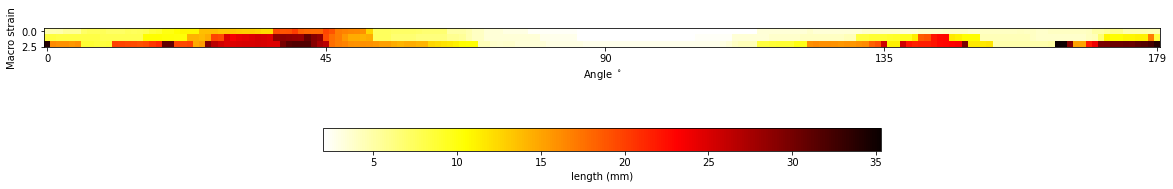

In [15]:
fig=plt.figure(figsize=(20,10))
plt.imshow(auto_lmax,cmap=cm.hot_r)
plt.gca().set_xticks([0,45,90,135,179])
#plt.gca().set_yticks([0,10])
#plt.gca().set_xticklabels(['x','+45$^\circ$','y','-45$^\circ$','x'])
#plt.gca().set_yticklabels([np.array(data[0].time[0]),np.array(data[0].time[10])])
plt.colorbar(orientation='horizontal',aspect=25,shrink=0.5,label='length (mm)')
plt.xlabel('Angle $^\circ$')
plt.ylabel('Macro strain')